## Probabilidade de Trânsito e Rankeamento de vias

Insira abaixo os parâmetros do relatório e selecione "Cell" -> "Run All" para gerar os relatórios. Estarão armazenados no S3 da Amazon.

In [1]:
dia_inicio = 15
mes_inicio = 3
ano_inicio = 2018

dia_fim = 15
mes_fim = 7
ano_fim = 2018

horarios = [7,8,17,18]
fins_de_semana = False

In [2]:
%matplotlib inline
import os
import sys
project_dir = os.path.join(os.pardir, os.pardir)
sys.path.append(project_dir)

import dotenv
dotenv_path = os.path.join(project_dir, '.env')
dotenv.load_dotenv(dotenv_path)

from IPython.display import display

import time
import numpy as np
import pandas as pd
import geopandas as gpd
import json
import datetime
from shapely.geometry import LineString, Point
from shapely.wkt import loads as wkt_loads
from geojson import Feature
import boto3
import io

import seaborn as sns
from matplotlib import pyplot as plt

from src.data import processing_func

import importlib
pd.options.display.max_columns = 30
pd.options.display.max_rows = 200

## Probabilidade de Trânsito

What the block below does is:
1. Connect to the "jams" table of the database. See database documentation for more information;
2. Retrieve 3 months of jams data as a Pandas dataframe;

In [3]:
#Connection and initial setup
DATABASE = {
'drivername': os.environ.get("db_drivername"),
'host': os.environ.get("db_host"), 
'port': os.environ.get("db_port"),
'username': os.environ.get("db_username"),
'password': os.environ.get("db_password"),
'database': os.environ.get("db_database"),
}

meta = processing_func.connect_database(DATABASE)

date_begin = datetime.date(day=dia_inicio, month=mes_inicio, year=ano_inicio)
date_end = datetime.date(day=dia_fim, month=mes_fim, year=ano_fim)

df_jams = processing_func.extract_df_jams(meta, date_begin, date_end, weekends=fins_de_semana)
display(df_jams.shape)
display(df_jams.head())

(1297953, 10)

,start_time,id,uuid,street,level,length,speed_kmh,speed,delay,line
0,2018-07-13 23:59:00,144956,1766425059,R. Otto Boehm,2,805,18.93,5.25833,70,"[{'x': -48.854705, 'y': -26.302192}, {'x': -48..."
1,2018-07-13 23:59:00,144956,1763107932,Tv. Maria Brito da Maia,2,180,5.23,1.45278,78,"[{'x': -48.822227, 'y': -26.269216}, {'x': -48..."
2,2018-07-13 23:59:00,144956,1766856009,R. Timbó,2,454,12.03,3.34167,74,"[{'x': -48.852581, 'y': -26.293511}, {'x': -48..."
3,2018-07-13 23:59:00,144956,1756314443,SC-418,1,3835,43.25,12.01390,152,"[{'x': -49.172884, 'y': -26.18554}, {'x': -49...."
4,2018-07-13 23:59:00,144956,1767854950,R. Mons. Gercino,3,628,13.71,3.80833,107,"[{'x': -48.837108, 'y': -26.331584}, {'x': -48..."


In [4]:
geo_jams = processing_func.transform_geo_jams(df_jams)
display(geo_jams.shape)
display(geo_jams.head())

(1297953, 20)

,start_time,id,uuid,street,level,length,speed_kmh,speed,delay,line,LonDirection,LatDirection,MajorDirection,date,hour,minute,period,minute_bin,jams_line_list,linestring
0,2018-07-13 20:59:00-03:00,144956,1766425059,R. Otto Boehm,2,805,18.93,5.25833,70,"[{'x': -48.854705, 'y': -26.302192}, {'x': -48...",West,South,East/West,2018-07-13,20,59,1,45 a 59,"[(-48.854705, -26.302192), (-48.856287, -26.30...",LINESTRING (714174.449566811 7089072.379100762...
1,2018-07-13 20:59:00-03:00,144956,1763107932,Tv. Maria Brito da Maia,2,180,5.23,1.45278,78,"[{'x': -48.822227, 'y': -26.269216}, {'x': -48...",West,South,East/West,2018-07-13,20,59,1,45 a 59,"[(-48.822227, -26.269216), (-48.822496, -26.26...",LINESTRING (717479.3516634256 7092671.77834399...
2,2018-07-13 20:59:00-03:00,144956,1766856009,R. Timbó,2,454,12.03,3.34167,74,"[{'x': -48.852581, 'y': -26.293511}, {'x': -48...",East,South,East/West,2018-07-13,20,59,1,45 a 59,"[(-48.852581, -26.293511), (-48.850126, -26.29...",LINESTRING (714402.5371680746 7090030.67536014...
3,2018-07-13 20:59:00-03:00,144956,1756314443,SC-418,1,3835,43.25,12.01390,152,"[{'x': -49.172884, 'y': -26.18554}, {'x': -49....",West,North,East/West,2018-07-13,20,59,1,45 a 59,"[(-49.172884, -26.18554), (-49.174078, -26.184...",LINESTRING (682584.3406378566 7102483.56037185...
4,2018-07-13 20:59:00-03:00,144956,1767854950,R. Mons. Gercino,3,628,13.71,3.80833,107,"[{'x': -48.837108, 'y': -26.331584}, {'x': -48...",East,South,East/West,2018-07-13,20,59,1,45 a 59,"[(-48.837108, -26.331584), (-48.836716, -26.33...",LINESTRING (715877.218763847 7085786.551076483...


In [5]:
#Connect to S3
s3 = boto3.client('s3',
                  aws_access_key_id=os.environ.get("aws_access_key"),
                  aws_secret_access_key=os.environ.get("aws_secret_key"))

# Filter holidays from list of holidays in Brazil, from ANBIMA
bucket = "smartmob-data"
key = "external/feriados_nacionais.xls"
result_dict = s3.get_object(Bucket=bucket, Key=key)
file_obj = io.BytesIO(result_dict["Body"].read())
holidays = pd.read_excel(file_obj, skipfooter=9)
holidays["Data"] = holidays["Data"].dt.date
holiday_list = holidays["Data"].tolist()
geo_jams = geo_jams[~geo_jams["date"].isin(holiday_list)]
display(geo_jams.shape)

#Let's drop blocked congestions. We'll treat them as outliers.
geo_jams = geo_jams[geo_jams["level"] != 5.0]
display(geo_jams.shape)

#Let's get data from selected periods only
geo_jams = geo_jams[geo_jams.hour.isin(horarios)]
display(geo_jams.shape)

(1285914, 20)

(1243045, 20)

(574892, 20)

In [6]:
geo_jams.sample(5)

,start_time,id,uuid,street,level,length,speed_kmh,speed,delay,line,LonDirection,LatDirection,MajorDirection,date,hour,minute,period,minute_bin,jams_line_list,linestring
640524,2018-05-09 08:11:00-03:00,99384,285055043,Av. Edgar Nelson Meister,3,875,11.60,3.22222,209,"[{'x': -48.863814, 'y': -26.250321}, {'x': -48...",West,South,East/West,2018-05-09,8,11,-1,0 a 14,"[(-48.863814, -26.250321), (-48.864299, -26.25...",LINESTRING (713359.7006742797 7094834.49698048...
1162160,2018-03-27 08:04:00-03:00,74716,730501795,R. Marq. de Olinda,3,591,11.56,3.21111,119,"[{'x': -48.862645, 'y': -26.269117}, {'x': -48...",East,North,North/South,2018-03-27,8,4,-1,0 a 14,"[(-48.862645, -26.269117), (-48.862558, -26.26...",LINESTRING (713442.1048511361 7092750.06873731...
198601,2018-06-27 08:51:00-03:00,119855,231238181,R. Florianópolis,3,537,13.61,3.78056,78,"[{'x': -48.82219, 'y': -26.332129}, {'x': -48....",East,South,East/West,2018-06-27,8,51,-1,45 a 59,"[(-48.82219, -26.332129), (-48.817476, -26.333...",LINESTRING (717365.5951351271 7085701.12918030...
913196,2018-04-16 17:40:00-03:00,87348,384920517,R. Camboriú,4,409,7.50,2.08333,167,"[{'x': -48.862597, 'y': -26.303286}, {'x': -48...",West,North,North/South,2018-04-16,17,40,1,30 a 44,"[(-48.862597, -26.303286), (-48.862653, -26.30...",LINESTRING (713384.3271704626 7088964.22659555...
1258598,2018-03-19 08:29:00-03:00,133328,69808222,R. 15 de Novembro,3,1542,10.61,2.94722,385,"[{'x': -48.884434, 'y': -26.296522}, {'x': -48...",East,North,East/West,2018-03-19,8,29,-1,15 a 29,"[(-48.884434, -26.296522), (-48.88421, -26.296...",LINESTRING (711215.9207880573 7089749.52071723...


Cross-reference jams data with georeferenced sections from geo

In [7]:
#Read WKT file from SIMGeo
bucket = "smartmob-data"
key = "external/sepud_logradouros_WKT_abr2018.csv"
result_dict = s3.get_object(Bucket=bucket, Key=key)
file_obj = io.BytesIO(result_dict["Body"].read())
df_sections = processing_func.wkt_to_df(file_obj)
display(df_sections.shape)
df_sections.head()

(16148, 6)

,id_arcgis,street_code,street_name,cumulative_meters,length,wkt
0,16092,2686,DR. JOAO COLIN,2335,89.08780944930,"MULTILINESTRING ((714734.1111 7091467.602,7147..."
1,16093,8937,SERVIDAO ARISTIDES FERREIRA,231,231.00851918600,"MULTILINESTRING ((712587.072 7090233.5129,7125..."
2,16094,21426,SD 21426,92,91.80110726550,"MULTILINESTRING ((711794.9619 7090331.3387,711..."
3,16095,40087,GUILHERME BUCH PEREIRA,61,60.98101166040,"MULTILINESTRING ((717162.3776 7083164.3607,717..."
4,16096,40131,SERVIDAO ISRAEL JOAO RODRIGUES,84,84.08718778730,"MULTILINESTRING ((716949.0883 7092081.4944,717..."


In [8]:
geo_sections = processing_func.transform_geo_sections(df_sections)
display(geo_sections.shape)
display(geo_sections.head())

(16148, 12)

,id_arcgis,street_code,street_name,cumulative_meters,length,linestring,min_x,min_y,max_x,max_y,street_direction,section_direction
0,16092,2686,DR. JOAO COLIN,2335,89.08780944930,"(LINESTRING (714734.1111 7091467.602, 714740.5...",714734.1111,7.091379e+06,714740.5956,7.091468e+06,Norte/Sul,Norte/Sul
1,16093,8937,SERVIDAO ARISTIDES FERREIRA,231,231.00851918600,"(LINESTRING (712587.072 7090233.5129, 712581.5...",712574.7055,7.090006e+06,712587.0720,7.090234e+06,Norte/Sul,Norte/Sul
2,16094,21426,SD 21426,92,91.80110726550,"(LINESTRING (711794.9619 7090331.3387, 711795....",711793.9437,7.090331e+06,711797.3378,7.090423e+06,Norte/Sul,Norte/Sul
3,16095,40087,GUILHERME BUCH PEREIRA,61,60.98101166040,"(LINESTRING (717162.3776 7083164.3607, 717169....",717162.3776,7.083164e+06,717169.0869,7.083225e+06,Norte/Sul,Norte/Sul
4,16096,40131,SERVIDAO ISRAEL JOAO RODRIGUES,84,84.08718778730,"(LINESTRING (716949.0882999999 7092081.4944, 7...",716949.0883,7.092081e+06,717006.8862,7.092143e+06,Norte/Sul,Norte/Sul


Allocate jams to street sections:

In [9]:
allocated_jams = processing_func.allocate_jams(geo_jams, geo_sections, big_buffer=20, small_buffer=10)
display(allocated_jams.shape)
display(allocated_jams.head())

(2986943, 35)

,start_time,id,uuid,street,level,length_jams,speed_kmh,speed,delay,line,LonDirection,LatDirection,MajorDirection,date,hour,...,direction_jams,index_net,id_arcgis,street_code,street_name,cumulative_meters,length_net,linestring_net,min_x,min_y,max_x,max_y,street_direction,section_direction,direction_net
0,2018-07-13 18:57:00-03:00,144895,1757510480,SC-108 Rod. Rodolfo Jahn,3,389,10.11,2.80833,84,"[{'x': -48.921403, 'y': -26.284114}, {'x': -48...",East,South,North/South,2018-07-13,18,...,Norte/Sul,13003.0,29460.0,5410.0,JULIO STOLF,656.0,388.23968290800,"(LINESTRING (707543.7356 7091185.1632, 707565....",707543.7356,7.090816e+06,707624.7526,7.091185e+06,Norte/Sul,Norte/Sul,Norte/Sul
1,2018-07-13 18:57:00-03:00,144895,1757219560,R. Tuiuti,3,951,16.77,4.65833,129,"[{'x': -48.821213, 'y': -26.249053}, {'x': -48...",East,South,North/South,2018-07-13,18,...,Norte/Sul,6054.0,22283.0,9288.0,TUIUTI,2373.0,74.31976237580,"(LINESTRING (717767.6934 7094598.4724, 717787....",717767.6934,7.094527e+06,717787.3565,7.094598e+06,Norte/Sul,Norte/Sul,Norte/Sul
2,2018-07-13 18:57:00-03:00,144895,1757219560,R. Tuiuti,3,951,16.77,4.65833,129,"[{'x': -48.821213, 'y': -26.249053}, {'x': -48...",East,South,North/South,2018-07-13,18,...,Norte/Sul,6053.0,22282.0,9288.0,TUIUTI,2441.0,68.46651369700,"(LINESTRING (717746.3626 7094663.5313, 717767....",717746.3626,7.094598e+06,717767.6934,7.094664e+06,Norte/Sul,Norte/Sul,Norte/Sul
3,2018-07-13 18:57:00-03:00,144895,1757219560,R. Tuiuti,3,951,16.77,4.65833,129,"[{'x': -48.821213, 'y': -26.249053}, {'x': -48...",East,South,North/South,2018-07-13,18,...,Norte/Sul,6052.0,22281.0,9288.0,TUIUTI,2506.0,65.03979066960,"(LINESTRING (717708.0292 7094716.0739, 717746....",717708.0292,7.094664e+06,717746.3626,7.094716e+06,Norte/Sul,Norte/Sul,Norte/Sul
4,2018-07-13 18:57:00-03:00,144895,1757219560,R. Tuiuti,3,951,16.77,4.65833,129,"[{'x': -48.821213, 'y': -26.249053}, {'x': -48...",East,South,North/South,2018-07-13,18,...,Norte/Sul,6051.0,22280.0,9288.0,TUIUTI,2579.0,73.14512790870,"(LINESTRING (717671.2341999999 7094779.0817, 7...",717671.2342,7.094716e+06,717708.0292,7.094779e+06,Norte/Sul,Norte/Sul,Norte/Sul


In [10]:
#Aggregate traffic in slots of 15 minutes
traffic_per_section_timeslots = (allocated_jams.groupby(["id_arcgis", "street_name", "street_code",
                                                         "cumulative_meters", "hour",
                                                         "minute_bin", "LonDirection",
                                                         "LatDirection", "MajorDirection"])
                                 .agg({"uuid": 'count',
                                       "length_jams": "mean",
                                       "speed_kmh": "mean",
                                       "delay": "mean",
                                       "level": "mean",
                                       "period": "max",
                                        })
                                 .rename(columns={'uuid': "count_uuid"})
                                )
print(traffic_per_section_timeslots.shape)
traffic_per_section_timeslots.sample(5)

(74455, 6)


,,,,,,,,,count_uuid,length_jams,speed_kmh,delay,level,period
id_arcgis,street_name,street_code,cumulative_meters,hour,minute_bin,LonDirection,LatDirection,MajorDirection,,,,,,
21302.0,MONSENHOR GERCINO,6239.0,1851.0,8,30 a 44,West,North,East/West,22,710.727273,12.262727,140.545455,3.272727,-1
22081.0,ANTONIO JORGE CECYN,180.0,214.0,18,30 a 44,East,South,East/West,1,895.000000,17.710000,75.000000,2.000000,1
29339.0,ESTRADA TIMBE,9325.0,1622.0,18,0 a 14,West,South,North/South,9,380.222222,6.770000,179.333333,3.555556,1
27353.0,BRASIL,1255.0,518.0,18,15 a 29,East,South,East/West,3,813.000000,20.703333,62.000000,2.000000,1
21095.0,MONSENHOR GERCINO,6239.0,3659.0,8,0 a 14,East,North,East/West,12,626.666667,13.122500,97.000000,2.750000,-1


In [11]:
#Get unique datafiles
wazesignals_per_timeslot = (allocated_jams
                            .groupby(["hour", "minute_bin"])
                            .agg({"start_time": pd.Series.nunique})
                            .rename(columns={"start_time": "count_datafiles"})
                           )

#Merge dataset with total number of waze signals, for each bin. jps stands for JamsPerSection

jps_per_timeslot = (traffic_per_section_timeslots
                    .reset_index()
                    .set_index(["hour", "minute_bin"])
                    .join(wazesignals_per_timeslot, how="outer")
                    .sort_index()
                   )

#For highly meshed networks it is possible that jams from neighbor streets be double counted in other sections.
#We are accepting that, but we need to cap the probability to 1 in case the numbers of jams is bigger than the
#numbers of Waze signals.
jps_per_timeslot["slot_traffic_prob"] = jps_per_timeslot["count_uuid"]/jps_per_timeslot["count_datafiles"]
jps_per_timeslot["slot_traffic_prob"] = jps_per_timeslot["slot_traffic_prob"].clip(upper=1)
jps_per_timeslot = jps_per_timeslot.join(df_sections.set_index("id_arcgis").wkt, on="id_arcgis")
display(jps_per_timeslot.shape)
display(jps_per_timeslot.sample(5))

#save to s3
timestamp = datetime.datetime.today().strftime("%Y_%m_%d_%H:%M:%S")
folder_name = "processed/%s_traffic_prob_from_%s%s_to_%s%s/" % (timestamp, 
                                                        date_begin.year,
                                                        date_begin.month,
                                                        date_end.year,
                                                        date_end.month)
file_name = folder_name + "congestion_per_timeslot.csv"
stream = io.StringIO()
jps_per_timeslot.to_csv(stream)
stream.seek(0)
s3.put_object(Body=stream.read(), Bucket='smartmob-data', Key=file_name)

(74455, 16)

,,id_arcgis,street_name,street_code,cumulative_meters,LonDirection,LatDirection,MajorDirection,count_uuid,length_jams,speed_kmh,delay,level,period,count_datafiles,slot_traffic_prob,wkt
hour,minute_bin,,,,,,,,,,,,,,,,
8,15 a 29,19469.0,FLORIANOPOLIS,3723.0,580.0,West,North,East/West,27,1293.222222,7.902963,428.370370,3.555556,-1,649,0.041602,"MULTILINESTRING ((715872.4902 7086592.2146,715..."
17,0 a 14,29308.0,MONSENHOR GERCINO,6239.0,5245.0,East,North,East/West,10,1063.400000,18.632000,90.600000,2.800000,1,617,0.016207,"MULTILINESTRING ((719138.0491 7084990.8256,719..."
18,15 a 29,23805.0,RIO GRANDE DO SUL,8322.0,418.0,West,North,East/West,142,641.000000,11.513803,174.401408,2.929577,1,655,0.216794,"MULTILINESTRING ((714316.4261 7087955.5531,714..."
8,0 a 14,21440.0,AVENIDA SANTOS DUMONT,131.0,554.0,East,South,North/South,55,753.181818,9.981818,218.963636,3.436364,-1,600,0.091667,"MULTILINESTRING ((714629.8969 7092897.9739,714..."
18,45 a 59,31883.0,MARQUES DE OLINDA,6206.0,3409.0,East,North,North/South,12,1107.250000,13.862500,165.416667,2.916667,1,651,0.018433,"MULTILINESTRING ((713508.7678 7093064.8152,713..."


{'ResponseMetadata': {'RequestId': '5E7B9CE468E230D0',
  'HostId': 'DBNNiE6AJ1SWN0kaawlpvplDlnXz+QPfdUnz/Y2bS9umAlx7Kwb+w33nBLV8/wNcAlVQoxI2KSY=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'DBNNiE6AJ1SWN0kaawlpvplDlnXz+QPfdUnz/Y2bS9umAlx7Kwb+w33nBLV8/wNcAlVQoxI2KSY=',
   'x-amz-request-id': '5E7B9CE468E230D0',
   'date': 'Tue, 24 Jul 2018 15:47:22 GMT',
   'etag': '"36879565fa1d9aeb3431992a7ed9a650"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"36879565fa1d9aeb3431992a7ed9a650"'}

In [13]:
jps_per_timeslot["notraffic_prob"] = 1 - jps_per_timeslot["slot_traffic_prob"]
jps_per_timeslot["weighted_speed_kmh"] = jps_per_timeslot["slot_traffic_prob"]*jps_per_timeslot["speed_kmh"]
jps_per_timeslot["weighted_length_jams"] = jps_per_timeslot["slot_traffic_prob"]*jps_per_timeslot["length_jams"]
jps_per_timeslot["weighted_delay"] = jps_per_timeslot["slot_traffic_prob"]*jps_per_timeslot["delay"]
jps_per_timeslot["weighted_level"] = jps_per_timeslot["slot_traffic_prob"]*jps_per_timeslot["level"]

traffic_prob = jps_per_timeslot.groupby(["id_arcgis", "street_name", "street_code",
                                               "cumulative_meters", "LonDirection", "LatDirection",
                                               "MajorDirection", "period"]).agg({"notraffic_prob": np.prod,
                                                                  "slot_traffic_prob": np.sum,
                                                                  "weighted_speed_kmh": np.sum,
                                                                  "weighted_length_jams": np.sum,
                                                                  "weighted_delay": np.sum,
                                                                  "weighted_level": np.sum}) 

traffic_prob["traffic_prob"] = 1 - traffic_prob["notraffic_prob"]
traffic_prob["wavg_speed_kmh"] = traffic_prob["weighted_speed_kmh"] / traffic_prob["slot_traffic_prob"]
traffic_prob["wavg_length_jams"] = traffic_prob["weighted_length_jams"] / traffic_prob["slot_traffic_prob"]
traffic_prob["wavg_delay"] = traffic_prob["weighted_delay"] / traffic_prob["slot_traffic_prob"]
traffic_prob["wavg_level"] = traffic_prob["weighted_level"] / traffic_prob["slot_traffic_prob"]
traffic_prob.drop(["weighted_speed_kmh",
                         "weighted_length_jams",
                         "weighted_delay",
                         "weighted_level",
                         "slot_traffic_prob",
                         "notraffic_prob"], axis=1, inplace=True)
traffic_prob = traffic_prob.sort_values("traffic_prob", ascending=False)

#Add WKT back into the df
display(traffic_prob.shape)
traffic_prob = traffic_prob.join(df_sections.set_index("id_arcgis").wkt, on="id_arcgis")
display(traffic_prob.shape)

#Improve readability
lkp_period = pd.DataFrame({"periodo": ["Manha", "Tarde"]}, index=[-1, 1])
traffic_prob = (traffic_prob
                .join(lkp_period, on="period")
                .reset_index("period", drop=True)
                .set_index("periodo", append=True)
               )

display(traffic_prob.head(10))


(18491, 5)

(18491, 6)

,,,,,,,,traffic_prob,wavg_speed_kmh,wavg_length_jams,wavg_delay,wavg_level,wkt
id_arcgis,street_name,street_code,cumulative_meters,LonDirection,LatDirection,MajorDirection,periodo,,,,,,
18530.0,OTTOKAR DOERFFEL,6936.0,598.0,West,South,East/West,Tarde,1.000000,9.536848,1073.539721,309.198610,3.513262,"MULTILINESTRING ((713569.9322 7087802.8459,713..."
18531.0,OTTOKAR DOERFFEL,6936.0,521.0,West,South,East/West,Tarde,1.000000,9.442130,1089.789537,316.155958,3.524789,"MULTILINESTRING ((713739.4233 7087837.0578,713..."
24568.0,FLORIANOPOLIS,3723.0,340.0,East,South,North/South,Tarde,1.000000,8.915690,552.703711,172.900061,3.306074,"MULTILINESTRING ((715740.0582 7086805.73,71580..."
30426.0,OTTOKAR DOERFFEL,6936.0,418.0,West,South,East/West,Tarde,1.000000,9.361063,1094.638379,319.728345,3.532576,"MULTILINESTRING ((713739.4233 7087837.0578,713..."
30369.0,FLORIANOPOLIS,3723.0,214.0,East,South,North/South,Tarde,1.000000,8.907987,552.819799,173.239314,3.306120,"MULTILINESTRING ((715671.1895 7086912.5474,715..."
21345.0,FLORIANOPOLIS,3723.0,440.0,East,South,North/South,Tarde,1.000000,8.930526,554.729994,173.106921,3.303085,"MULTILINESTRING ((715806.8624 7086698.5693,715..."
24999.0,OTTOKAR DOERFFEL,6936.0,708.0,West,South,East/West,Tarde,1.000000,9.688864,1099.426718,311.908033,3.494438,"MULTILINESTRING ((713495.153 7087723.1534,7135..."
24247.0,ANITA GARIBALDI,71.0,854.0,West,South,East/West,Tarde,1.000000,9.646505,772.619900,221.978757,3.547880,"MULTILINESTRING ((714418.4811 7087042.7474,714..."
29260.0,ANITA GARIBALDI,71.0,729.0,West,South,East/West,Tarde,1.000000,9.638085,773.939624,222.768566,3.553760,"MULTILINESTRING ((714503.5143 7087134.4059,714..."


In [14]:
file_name = folder_name + "traffic_prob.csv" 

#Save as GeoJSON                       
#geo_traffic_indicators.to_file(project_dir + "/data/interim/" + file_name, driver="GeoJSON")

#Save as CSV
# def add_geojson(df):
#     df["geojson"] = df.apply(lambda row: json.dumps(Feature(geometry=row.section_LineString)), axis=1)
#     return df

#geo_traffic_indicators = geo_traffic_indicators.pipe(add_geojson)
stream = io.StringIO()
traffic_prob.to_csv(stream)
stream.seek(0)
s3.put_object(Body=stream.read(), Bucket='smartmob-data', Key=file_name)

{'ResponseMetadata': {'RequestId': '2B36E057C06E7FAE',
  'HostId': 'mF9zTZVSVKPe1A6o7OzCWSzb0epNFWxgtcQU7P55mVpdKNyLh4BAHxVIOZfOYOu+gqjIggtkcqw=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'mF9zTZVSVKPe1A6o7OzCWSzb0epNFWxgtcQU7P55mVpdKNyLh4BAHxVIOZfOYOu+gqjIggtkcqw=',
   'x-amz-request-id': '2B36E057C06E7FAE',
   'date': 'Tue, 24 Jul 2018 15:48:33 GMT',
   'etag': '"14d7dff5520578ac12e8c51b06fa0c0c"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"14d7dff5520578ac12e8c51b06fa0c0c"'}

## Rankeamento de Vias

In [15]:
#Creation of an indicator of traffic criticity
gdf_ranking = traffic_prob.copy().reset_index()
gdf_ranking["criticidade"] = gdf_ranking["traffic_prob"]*gdf_ranking["wavg_delay"]

gdf_ranking.sort_values("criticidade", ascending=False).head()

,id_arcgis,street_name,street_code,cumulative_meters,LonDirection,LatDirection,MajorDirection,periodo,traffic_prob,wavg_speed_kmh,wavg_length_jams,wavg_delay,wavg_level,wkt,criticidade
1303,17229.0,GOVERNADOR MARIO COVAS,1252.0,10619.0,West,North,North/South,Tarde,0.704809,10.726556,5141.82431,1586.954178,3.98774,"MULTILINESTRING ((708187.4466 7098332.3851,708...",1118.499081
1304,31367.0,GOVERNADOR MARIO COVAS,1252.0,9756.0,West,North,North/South,Tarde,0.704809,10.726556,5141.82431,1586.954178,3.98774,"MULTILINESTRING ((708191.8022 7098408.4729,708...",1118.499081
1305,17244.0,GOVERNADOR MARIO COVAS,1252.0,9832.0,West,North,North/South,Tarde,0.704809,10.726556,5141.82431,1586.954178,3.98774,"MULTILINESTRING ((708191.8022 7098408.4729,708...",1118.499081
1306,30967.0,GOVERNADOR MARIO COVAS,1252.0,11468.0,West,North,North/South,Tarde,0.704809,10.726556,5141.82431,1586.954178,3.98774,"MULTILINESTRING ((708162.0456 7096705.4858,708...",1118.499081
1307,29941.0,GOVERNADOR MARIO COVAS,1252.0,9288.0,West,North,North/South,Tarde,0.704809,10.726556,5141.82431,1586.954178,3.98774,"MULTILINESTRING ((708320.0199 7099592.6849,708...",1118.499081


#### Classificação Funcional das vias

In [16]:
# Filter holidays from list of holidays in Brazil, from ANBIMA
bucket = "smartmob-data"
key = "external/sepud_vias_arteriais.csv"
result_dict = s3.get_object(Bucket=bucket, Key=key)
file_obj = io.BytesIO(result_dict["Body"].read())
arteriais = pd.read_csv(file_obj, sep=";", encoding="latin-1")

bucket = "smartmob-data"
key = "external/sepud_vias_coletoras.csv"
result_dict = s3.get_object(Bucket=bucket, Key=key)
file_obj = io.BytesIO(result_dict["Body"].read())
coletoras = pd.read_csv(file_obj, sep=";", encoding="latin-1")

arteriais.drop_duplicates(["nomelog", "tipo_via_"], inplace=True)
coletoras.drop_duplicates(["nomelog", "tipo_via_"], inplace=True)

arteriais = arteriais[["nomelog", "tipo_via_"]]
coletoras = coletoras[["nomelog", "tipo_via_"]]

#The functional classification increases the criticity of the street

bonus_arterial = 1.3
bonus_collector = 1.1
bonus_local = 1

arteriais["ClassFunc_bonus"] = bonus_arterial
coletoras["ClassFunc_bonus"] = bonus_collector

class_func = arteriais.append(coletoras)
class_func.set_index("nomelog", inplace=True)
class_func.rename(columns={"tipo_via_": "ClassFunc"}, inplace=True)

gdf_clf = gdf_ranking.join(class_func, on="street_name")
gdf_clf["ClassFunc"].fillna(value="LOCAL/OUTRO", inplace=True)
gdf_clf["ClassFunc_bonus"].fillna(value=bonus_local, inplace=True)

#Manual Corrections
gdf_clf.loc[gdf_clf["street_name"] == "OTTO PARUCKER", "ClassFunc"] = "ARTERIAL"
gdf_clf.loc[gdf_clf["street_name"] == "OTTO PARUCKER", "ClassFunc_bonus"] = bonus_arterial

gdf_clf.loc[gdf_clf["street_name"] == "CAMBORIU", "ClassFunc"] = "ARTERIAL"
gdf_clf.loc[gdf_clf["street_name"] == "CAMBORIU", "ClassFunc_bonus"] = bonus_arterial

#Adjust criticity with functional classification
gdf_clf["criticidade"] = gdf_clf["criticidade"]*gdf_clf["ClassFunc_bonus"]
gdf_clf.sort_values(["criticidade"], ascending=False, inplace=True)

gdf_clf.head()

,id_arcgis,street_name,street_code,cumulative_meters,LonDirection,LatDirection,MajorDirection,periodo,traffic_prob,wavg_speed_kmh,wavg_length_jams,wavg_delay,wavg_level,wkt,criticidade,ClassFunc,ClassFunc_bonus
1303,17229.0,GOVERNADOR MARIO COVAS,1252.0,10619.0,West,North,North/South,Tarde,0.704809,10.726556,5141.82431,1586.954178,3.98774,"MULTILINESTRING ((708187.4466 7098332.3851,708...",1118.499081,LOCAL/OUTRO,1.0
1304,31367.0,GOVERNADOR MARIO COVAS,1252.0,9756.0,West,North,North/South,Tarde,0.704809,10.726556,5141.82431,1586.954178,3.98774,"MULTILINESTRING ((708191.8022 7098408.4729,708...",1118.499081,LOCAL/OUTRO,1.0
1305,17244.0,GOVERNADOR MARIO COVAS,1252.0,9832.0,West,North,North/South,Tarde,0.704809,10.726556,5141.82431,1586.954178,3.98774,"MULTILINESTRING ((708191.8022 7098408.4729,708...",1118.499081,LOCAL/OUTRO,1.0
1306,30967.0,GOVERNADOR MARIO COVAS,1252.0,11468.0,West,North,North/South,Tarde,0.704809,10.726556,5141.82431,1586.954178,3.98774,"MULTILINESTRING ((708162.0456 7096705.4858,708...",1118.499081,LOCAL/OUTRO,1.0
1307,29941.0,GOVERNADOR MARIO COVAS,1252.0,9288.0,West,North,North/South,Tarde,0.704809,10.726556,5141.82431,1586.954178,3.98774,"MULTILINESTRING ((708320.0199 7099592.6849,708...",1118.499081,LOCAL/OUTRO,1.0


#### Ranking por Trecho

In [17]:
print("Os 10 trechos mais críticos de Joinville: ")
display(gdf_clf.head(10))

#Save to S3
file_name = folder_name + "ranking_por_trecho.csv"
stream = io.StringIO()
gdf_clf.to_csv(stream)
stream.seek(0)
s3.put_object(Body=stream.read(), Bucket='smartmob-data', Key=file_name)

Os 10 trechos mais críticos de Joinville: 


,id_arcgis,street_name,street_code,cumulative_meters,LonDirection,LatDirection,MajorDirection,periodo,traffic_prob,wavg_speed_kmh,wavg_length_jams,wavg_delay,wavg_level,wkt,criticidade,ClassFunc,ClassFunc_bonus
1303,17229.0,GOVERNADOR MARIO COVAS,1252.0,10619.0,West,North,North/South,Tarde,0.704809,10.726556,5141.824310,1586.954178,3.987740,"MULTILINESTRING ((708187.4466 7098332.3851,708...",1118.499081,LOCAL/OUTRO,1.0
1304,31367.0,GOVERNADOR MARIO COVAS,1252.0,9756.0,West,North,North/South,Tarde,0.704809,10.726556,5141.824310,1586.954178,3.987740,"MULTILINESTRING ((708191.8022 7098408.4729,708...",1118.499081,LOCAL/OUTRO,1.0
1305,17244.0,GOVERNADOR MARIO COVAS,1252.0,9832.0,West,North,North/South,Tarde,0.704809,10.726556,5141.824310,1586.954178,3.987740,"MULTILINESTRING ((708191.8022 7098408.4729,708...",1118.499081,LOCAL/OUTRO,1.0
1306,30967.0,GOVERNADOR MARIO COVAS,1252.0,11468.0,West,North,North/South,Tarde,0.704809,10.726556,5141.824310,1586.954178,3.987740,"MULTILINESTRING ((708162.0456 7096705.4858,708...",1118.499081,LOCAL/OUTRO,1.0
1307,29941.0,GOVERNADOR MARIO COVAS,1252.0,9288.0,West,North,North/South,Tarde,0.704809,10.726556,5141.824310,1586.954178,3.987740,"MULTILINESTRING ((708320.0199 7099592.6849,708...",1118.499081,LOCAL/OUTRO,1.0
1721,31375.0,GOVERNADOR MARIO COVAS,1252.0,13327.0,West,North,North/South,Tarde,0.558626,10.657254,5328.172116,1645.945730,3.947914,"MULTILINESTRING ((708834.2354 7094992.8985,708...",919.468650,LOCAL/OUTRO,1.0
565,29176.0,DONA FRANCISCA,2650.0,4131.0,West,North,East/West,Manha,0.940987,7.990727,1411.402383,641.338198,3.602637,"MULTILINESTRING ((714404.3517 7092624.2937,714...",784.537978,ARTERIAL,1.3
387,29175.0,DONA FRANCISCA,2650.0,4215.0,West,North,East/West,Manha,0.974506,8.051892,1364.172325,615.550012,3.602465,"MULTILINESTRING ((714332.4832 7092667.0938,714...",779.814045,ARTERIAL,1.3
753,29177.0,DONA FRANCISCA,2650.0,4057.0,West,North,East/West,Manha,0.889943,8.076421,1460.969262,661.393209,3.587839,"MULTILINESTRING ((714460.475 7092577.3327,7145...",765.182993,ARTERIAL,1.3
336,29174.0,DONA FRANCISCA,2650.0,4340.0,West,North,East/West,Manha,0.983031,8.154064,1338.071554,596.249856,3.592871,"MULTILINESTRING ((714222.5638 7092726.5065,714...",761.971987,ARTERIAL,1.3


{'ResponseMetadata': {'RequestId': 'C0B95E38BAE33941',
  'HostId': '0xvoYV64tDw9++SjrniLWu5VncgujKMjIaDKeZmdrpDLAIKdRfpM3nwEP9AZNtQbTbPcdcqmYgI=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '0xvoYV64tDw9++SjrniLWu5VncgujKMjIaDKeZmdrpDLAIKdRfpM3nwEP9AZNtQbTbPcdcqmYgI=',
   'x-amz-request-id': 'C0B95E38BAE33941',
   'date': 'Tue, 24 Jul 2018 15:48:49 GMT',
   'etag': '"01b9d0bd39c28f6de6f6e6cf3423e8e9"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"01b9d0bd39c28f6de6f6e6cf3423e8e9"'}

#### Ranking por Rua

In [18]:
print("As 10 ruas mais críticas de Joinville: ")
ranking_ruas = gdf_clf.drop_duplicates("street_name")

display(ranking_ruas.head(10))

#Save to S3
file_name = folder_name + "ranking_por_rua.csv"
stream = io.StringIO()
ranking_ruas.to_csv(stream)
stream.seek(0)
s3.put_object(Body=stream.read(), Bucket='smartmob-data', Key=file_name)

As 10 ruas mais críticas de Joinville: 


,id_arcgis,street_name,street_code,cumulative_meters,LonDirection,LatDirection,MajorDirection,periodo,traffic_prob,wavg_speed_kmh,wavg_length_jams,wavg_delay,wavg_level,wkt,criticidade,ClassFunc,ClassFunc_bonus
1303,17229.0,GOVERNADOR MARIO COVAS,1252.0,10619.0,West,North,North/South,Tarde,0.704809,10.726556,5141.824310,1586.954178,3.987740,"MULTILINESTRING ((708187.4466 7098332.3851,708...",1118.499081,LOCAL/OUTRO,1.0
565,29176.0,DONA FRANCISCA,2650.0,4131.0,West,North,East/West,Manha,0.940987,7.990727,1411.402383,641.338198,3.602637,"MULTILINESTRING ((714404.3517 7092624.2937,714...",784.537978,ARTERIAL,1.3
689,32019.0,OTTOKAR DOERFFEL,6936.0,1988.0,East,North,East/West,Manha,0.907755,8.261794,1514.100999,589.859367,3.839579,"MULTILINESTRING ((712428.1968 7087266.0119,712...",696.081896,ARTERIAL,1.3
794,19730.0,GUANABARA,4057.0,1989.0,West,North,East/West,Manha,0.878109,7.586564,1159.470645,539.454416,3.519297,"MULTILINESTRING ((717282.9122 7087017.7242,717...",615.809684,ARTERIAL,1.3
368,25565.0,QUINZE DE NOVEMBRO,8274.0,3338.0,West,South,East/West,Tarde,0.977400,9.508123,1450.801170,482.356536,3.389244,"MULTILINESTRING ((712289.3856 7089840.4863,712...",612.891900,ARTERIAL,1.3
916,31786.0,CEL. PROCOPIO GOMES,129.0,787.0,East,South,North/South,Tarde,0.840817,8.029137,1220.216409,468.708534,3.453367,"MULTILINESTRING ((715547.1998 7087968.1364,715...",512.327376,ARTERIAL,1.3
211,25076.0,ANITA GARIBALDI,71.0,1689.0,East,North,East/West,Tarde,0.997180,11.880839,1702.460202,392.721965,3.185283,"MULTILINESTRING ((714073.4018 7086674.5636,714...",509.098727,ARTERIAL,1.3
927,29117.0,TUIUTI,9288.0,5919.0,East,South,North/South,Tarde,0.838106,5.815183,793.491464,462.162007,3.794427,"MULTILINESTRING ((717605.5406 7097973.8931,717...",503.543202,ARTERIAL,1.3
312,29596.0,FLORIANOPOLIS,3723.0,1633.0,East,South,East/West,Tarde,0.986302,13.014522,1913.042188,392.581249,3.021115,"MULTILINESTRING ((716584.6964 7085837.7769,716...",503.364792,ARTERIAL,1.3
1010,21832.0,TENENTE ANTONIO JOAO,9254.0,1211.0,West,North,North/South,Manha,0.810762,11.934219,1918.168117,473.270402,3.331783,"MULTILINESTRING ((715230.9998 7093117.9664,715...",498.822499,ARTERIAL,1.3


{'ResponseMetadata': {'RequestId': '48812385A3A91926',
  'HostId': 'GCnHYZRALrxkh/DPwBBsRc79MCI7Xgf9arC05aKdV55+Wq1HO/UK3Fke29lVz4aAbMPiFTONe0s=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'GCnHYZRALrxkh/DPwBBsRc79MCI7Xgf9arC05aKdV55+Wq1HO/UK3Fke29lVz4aAbMPiFTONe0s=',
   'x-amz-request-id': '48812385A3A91926',
   'date': 'Tue, 24 Jul 2018 15:48:51 GMT',
   'etag': '"2ec2cc68b7a59cc735ae9b0abc433fbe"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"2ec2cc68b7a59cc735ae9b0abc433fbe"'}

<Figure size 432x288 with 0 Axes>

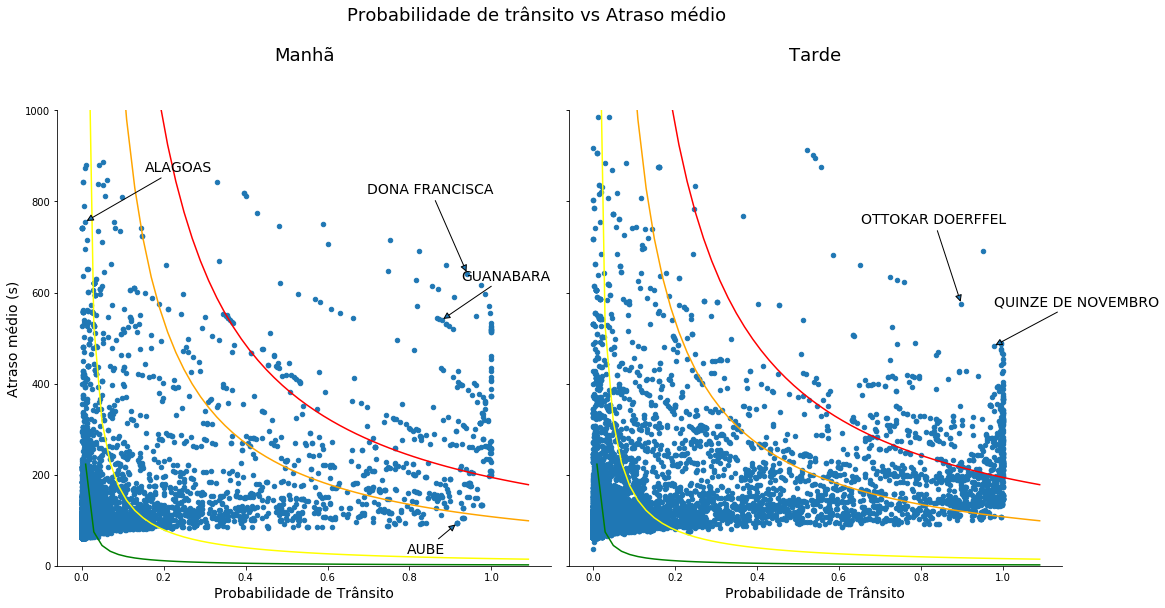

{'ResponseMetadata': {'RequestId': 'B13D77A5496054BF',
  'HostId': 'DRjZgbiTwx4FhyIgE7hCgZ7hdlfD7QdBAvGTX+5zHxQKiZWSzjKbVP03LsU/KRk3l+atvz0xzTw=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'DRjZgbiTwx4FhyIgE7hCgZ7hdlfD7QdBAvGTX+5zHxQKiZWSzjKbVP03LsU/KRk3l+atvz0xzTw=',
   'x-amz-request-id': 'B13D77A5496054BF',
   'date': 'Tue, 24 Jul 2018 15:49:21 GMT',
   'etag': '"5fc18483cf88d873c192da6a057f11aa"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"5fc18483cf88d873c192da6a057f11aa"'}

In [19]:
plt.clf()
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figheight(8)
f.set_figwidth(15)

gdf_clf[gdf_clf["periodo"] == "Manha"].plot("traffic_prob", "wavg_delay", kind="scatter", ax=ax1)
gdf_clf[gdf_clf["periodo"] == "Tarde"].plot("traffic_prob", "wavg_delay", kind="scatter", ax=ax2)

threshold_1 = np.percentile(gdf_clf["criticidade"], 50)
threshold_2 = np.percentile(gdf_clf["criticidade"], 75)
threshold_3 = np.percentile(gdf_clf["criticidade"], 90)
threshold_4 = np.percentile(gdf_clf["criticidade"], 95)

x = np.arange(0.01, 1.1, 0.02)
y = threshold_1/x
ax1.plot(x,y, color="green")
ax2.plot(x,y, color="green")

x = np.arange(0.01, 1.1, 0.02)
y = threshold_2/x
ax1.plot(x,y, color="yellow")
ax2.plot(x,y, color="yellow")

x = np.arange(0.01, 1.1, 0.02)
y = threshold_3/x
ax1.plot(x,y, color="orange")
ax2.plot(x,y, color="orange")

x = np.arange(0.01, 1.1, 0.02)
y = threshold_4/x
ax1.plot(x,y, color="red")
ax2.plot(x,y, color="red")

#Annotations - Morning
morning_critical = gdf_clf[gdf_clf["periodo"] == "Manha"].sort_values("criticidade", ascending=False).drop_duplicates("street_name")

first_order=0
first_morn_rua = morning_critical["street_name"].iloc[first_order]
first_morn_point = morning_critical[["traffic_prob", "wavg_delay"]].iloc[first_order]

second_order=2
second_morn_rua = morning_critical["street_name"].iloc[second_order]
second_morn_point = morning_critical[["traffic_prob", "wavg_delay"]].iloc[second_order]

low_prob = morning_critical.loc[(morning_critical.traffic_prob < 0.4) &
                            (morning_critical.wavg_delay > 500) & 
                            (morning_critical.wavg_delay < 1000)].iloc[1]
low_prob_rua = low_prob.street_name
low_prob_point = low_prob[["traffic_prob", "wavg_delay"]]

high_prob = morning_critical.loc[(morning_critical.traffic_prob > 0.9) &
                            (morning_critical.wavg_delay < 100)].iloc[0]
high_prob_rua = high_prob.street_name
high_prob_point = high_prob[["traffic_prob", "wavg_delay"]]

ax1.annotate(first_morn_rua,
             xy=first_morn_point,
             xytext=(-100, 80),
             textcoords="offset points",
             arrowprops=dict(arrowstyle='-|>'),
             fontsize=14)

ax1.annotate(second_morn_rua,
             xy=second_morn_point,
             xytext=(20, 40),
             textcoords="offset points",
             arrowprops=dict(arrowstyle='-|>'),
             fontsize=14)

ax1.annotate(low_prob_rua,
             xy=low_prob_point,
             xytext=(60, 50),
             textcoords="offset points",
             arrowprops=dict(arrowstyle='-|>'),
             fontsize=14)

ax1.annotate(high_prob_rua,
             xy=high_prob_point,
             xytext=(-50, -30),
             textcoords="offset points",
             arrowprops=dict(arrowstyle='-|>'),
             fontsize=14)

#Annotations - Afternoon
aftern_critical = gdf_clf[gdf_clf["periodo"] == "Tarde"].sort_values("criticidade", ascending=False).drop_duplicates("street_name")

first_order=1
first_aftern_rua = aftern_critical["street_name"].iloc[first_order]
first_aftern_point = aftern_critical[["traffic_prob", "wavg_delay"]].iloc[first_order]

second_order=2
second_aftern_rua = aftern_critical["street_name"].iloc[second_order]
second_aftern_point = aftern_critical[["traffic_prob", "wavg_delay"]].iloc[second_order]

ax2.annotate(first_aftern_rua,
             xy=first_aftern_point,
             xytext=(-100, 80),
             textcoords="offset points",
             arrowprops=dict(arrowstyle='-|>'),
             fontsize=14)

ax2.annotate(second_aftern_rua,
             xy=second_aftern_point,
             xytext=(0, 40),
             textcoords="offset points",
             arrowprops=dict(arrowstyle='-|>'),
             fontsize=14)


ax1.set_ylim([0,1000])
ax1.set_title("Manhã", fontsize=18, pad=50)
ax2.set_title("Tarde", fontsize=18, pad=50)
ax1.set_xlabel("Probabilidade de Trânsito")
ax2.set_xlabel("Probabilidade de Trânsito")
ax1.set_ylabel("Atraso médio (s)")
ax1.xaxis.label.set_size(14)
ax1.yaxis.label.set_size(14)
ax2.xaxis.label.set_size(14)
ax2.yaxis.label.set_size(14)

#Remove spines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)


fig = plt.gcf()
fig.suptitle("Probabilidade de trânsito vs Atraso médio", fontsize=18, y=1.05)
plt.tight_layout()

plt.show()

#Save to S3
file_name = folder_name + "grafico_ranking.png"
buf = io.BytesIO()
fig.savefig(buf, format='png', bbox_inches='tight')
buf.seek(0)
s3.put_object(Body=buf, Bucket='smartmob-data', ContentType='image/png', Key=file_name)